In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
s_file = up.open("/users/santoshp/BCVSPIN_Masterclass/BCVSPIN_Data/train_set/signal_train.root")
b_file = up.open("/users/santoshp/BCVSPIN_Masterclass/BCVSPIN_Data/train_set/bkg_train.root")

s_tree = s_file['tree']
b_tree = b_file['tree']


branch_names = ['lep_pt_0','lep_pt_1','lep_pt_2','lep_pt_3','deltaR_l0_l1','deltaR_l0_l2','deltaR_l0_l3',
 'deltaR_l1_l2','deltaR_l1_l3','deltaR_l2_l3' ,'invariant_mass_4lep'
]

s_arrays = s_tree.arrays(branch_names, library="pd")
b_arrays = b_tree.arrays(branch_names, library="pd")


df_s = pd.DataFrame(s_arrays)
df_b = pd.DataFrame(b_arrays)


In [3]:
#b_tree.keys()

In [4]:
df_s['Class'] = 1
df_b['Class'] = 0

print("Total Signal events: ",len(df_s))
print("Total Bkg events: ",len(df_b))


Total Signal events:  185020
Total Bkg events:  342174


In [5]:
df = pd.concat([df_s, df_b]).reset_index(drop=True).sample(frac=1)
y_df = df.pop('Class')

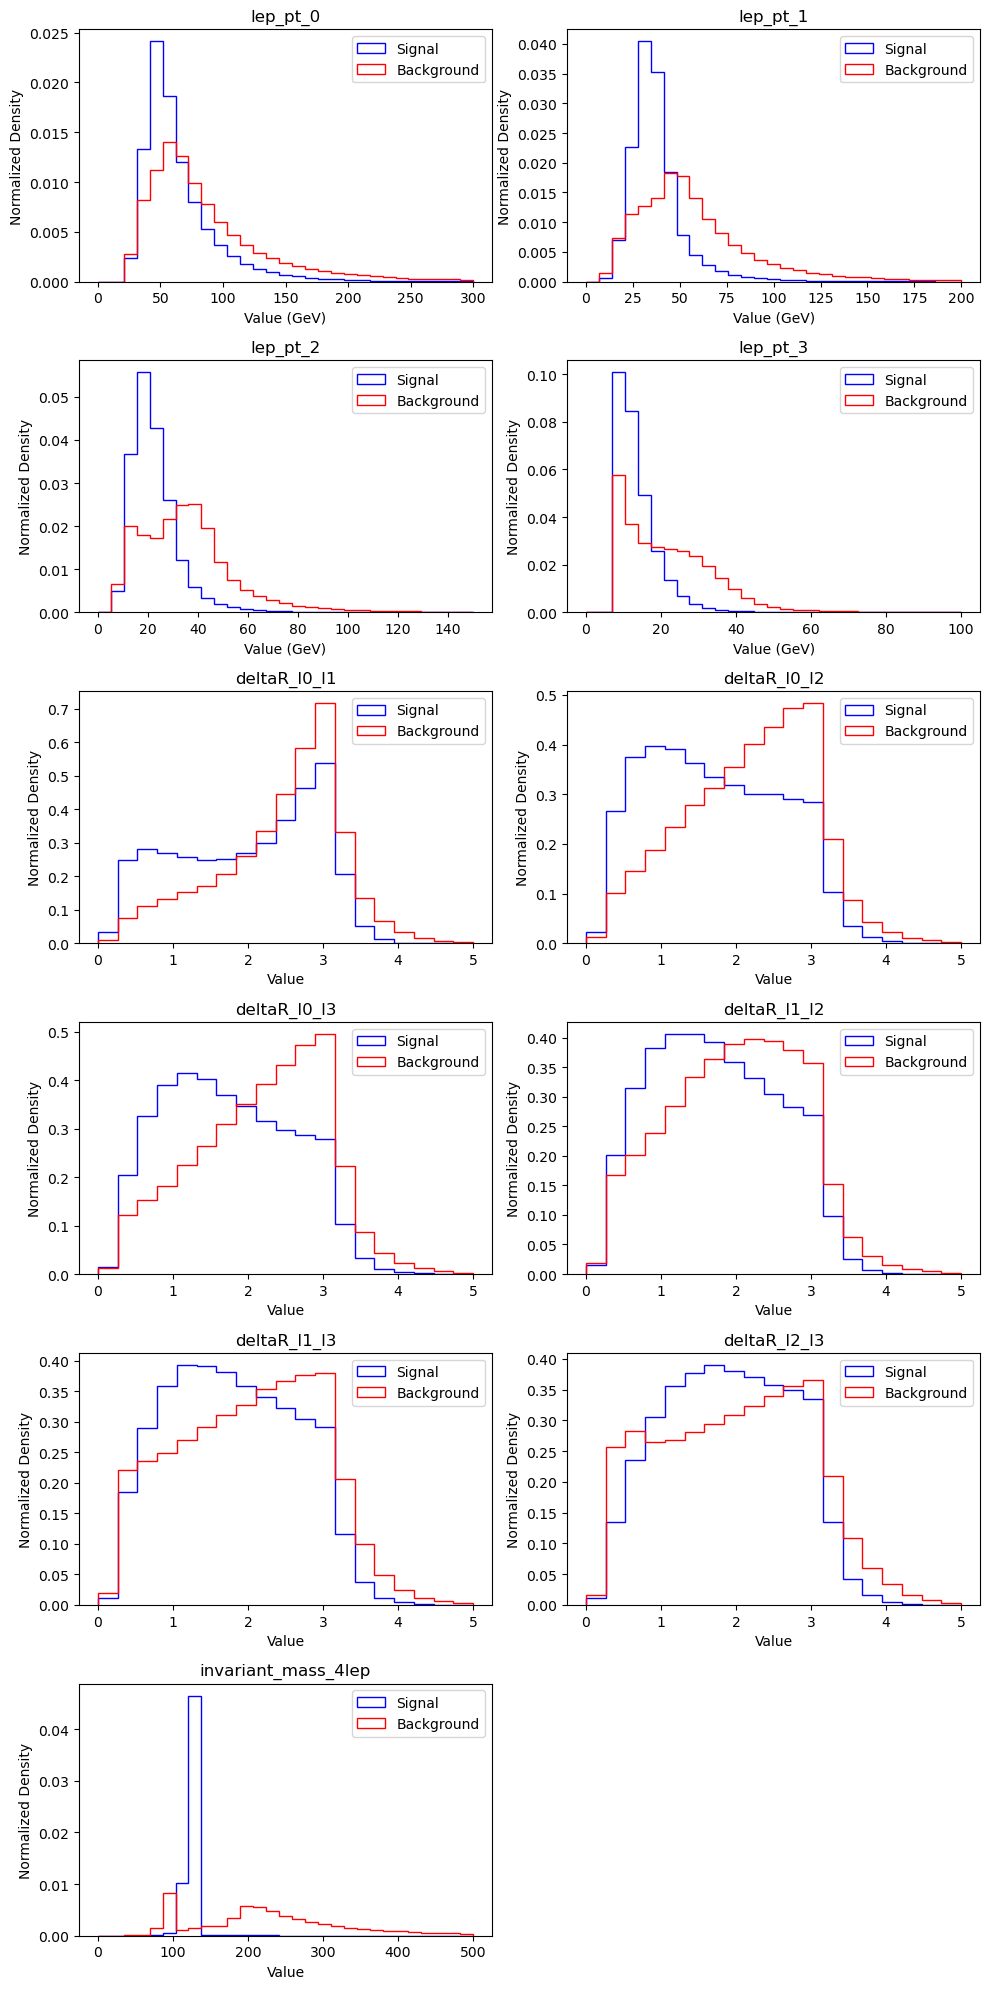

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define features and bin ranges
features = [
    'lep_pt_0', 'lep_pt_1', 'lep_pt_2', 'lep_pt_3',
     'deltaR_l0_l1', 'deltaR_l0_l2',
    'deltaR_l0_l3', 'deltaR_l1_l2', 'deltaR_l1_l3', 'deltaR_l2_l3' ,'invariant_mass_4lep'
]

# Specify bin ranges for each feature
bin_ranges = {
    'lep_pt_0': (0, 300, 30),
    'lep_pt_1': (0, 200, 30),
    'lep_pt_2': (0, 150, 30),
    'lep_pt_3': (0, 100, 30),
    'deltaR_l0_l1': (0, 5, 20),
    'deltaR_l0_l2': (0, 5, 20),
    'deltaR_l0_l3': (0, 5, 20),
    'deltaR_l1_l2': (0, 5, 20),
    'deltaR_l1_l3': (0, 5, 20),
    'deltaR_l2_l3': (0, 5, 20),
    'invariant_mass_4lep': (0, 500, 30),


}

# Plotting normalized distributions of features for signal and background
plt.figure(figsize=(10, 20))

# Create subplots for each feature
for i, feature in enumerate(features):
    plt.subplot(6, 2, i + 1)  
    bin_range = bin_ranges[feature]
    bins = np.linspace(bin_range[0], bin_range[1], bin_range[2])
    
    # Check if the feature is one of the lepton pt features
    if 'lep_pt' in feature or feature == 'invariant_mass_4lep':
        # Convert from MeV to GeV
        signal_data = df_s[feature] / 1000  # Convert Signal pt to GeV
        background_data = df_b[feature] / 1000  # Convert Background pt to GeV
    else:
        signal_data = df_s[feature]
        background_data = df_b[feature]

    # Plot the histograms as step type
    plt.hist(signal_data, bins=bins, alpha=1.0, label='Signal', density=True, color='blue', histtype='step')
    plt.hist(background_data, bins=bins, alpha=1.0, label='Background', density=True, color='red', histtype='step')
    
    # Title and labels
    plt.title(feature)
    plt.xlabel('Value (GeV)' if 'lep_pt' in feature else 'Value')
    plt.ylabel('Normalized Density')
    plt.legend()

# Improve layout
plt.tight_layout()
plt.show()


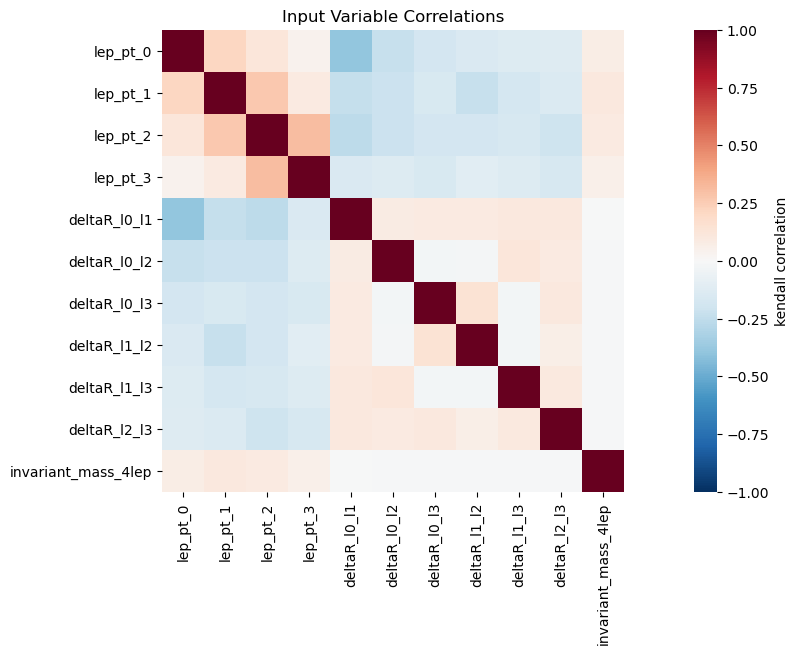

In [7]:
method = 'kendall'
correlations = df_s[branch_names].astype(np.float64).corr(method = method) # Kendall correlation coefficient ...
plt.figure(figsize = (18,6))
sns.heatmap(correlations, vmin = -1, annot = False, square = True, cbar_kws = {'label' : method+' correlation'}, cmap="RdBu_r")
plt.title('Input Variable Correlations')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import xgboost as xgb


X_train,X_test,y_train,y_test = train_test_split(df[branch_names],y_df,test_size=0.2,random_state=0)

In [9]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [10]:
clf = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')

Accuracy: 0.975322224224433
Precision: 0.9539326728510236


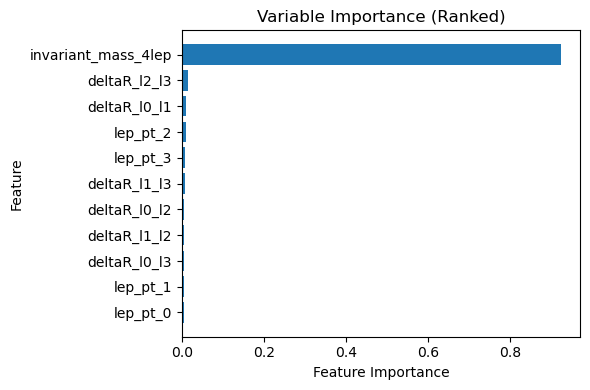

Rank 1: Feature: lep_pt_0, Importance Score: 0.004288501106202602
Rank 2: Feature: lep_pt_1, Importance Score: 0.004532469902187586
Rank 3: Feature: deltaR_l0_l3, Importance Score: 0.005395498126745224
Rank 4: Feature: deltaR_l1_l2, Importance Score: 0.006002911366522312
Rank 5: Feature: deltaR_l0_l2, Importance Score: 0.00655692582949996
Rank 6: Feature: deltaR_l1_l3, Importance Score: 0.007168033625930548
Rank 7: Feature: lep_pt_3, Importance Score: 0.007285537198185921
Rank 8: Feature: lep_pt_2, Importance Score: 0.009414835833013058
Rank 9: Feature: deltaR_l0_l1, Importance Score: 0.010368500836193562
Rank 10: Feature: deltaR_l2_l3, Importance Score: 0.014888618141412735
Rank 11: Feature: invariant_mass_4lep, Importance Score: 0.9240981340408325


In [11]:
importance = clf.feature_importances_

sorted_indices = sorted(range(len(importance)), key=lambda i: importance[i])
sorted_branch_names = [branch_names[i] for i in sorted_indices]
sorted_importance = [importance[i] for i in sorted_indices]

plt.figure(figsize=(6, 4))  # Adjust figure size as needed
plt.barh(range(11), sorted_importance[-11:], tick_label=sorted_branch_names[-11:])

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Variable Importance (Ranked)')
plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
plt.show()

for i, (name, score) in enumerate(zip(sorted_branch_names, sorted_importance), 1):
    print(f"Rank {i}: Feature: {name}, Importance Score: {score}")

In [12]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm

array([[66537,  1753],
       [  849, 36300]])

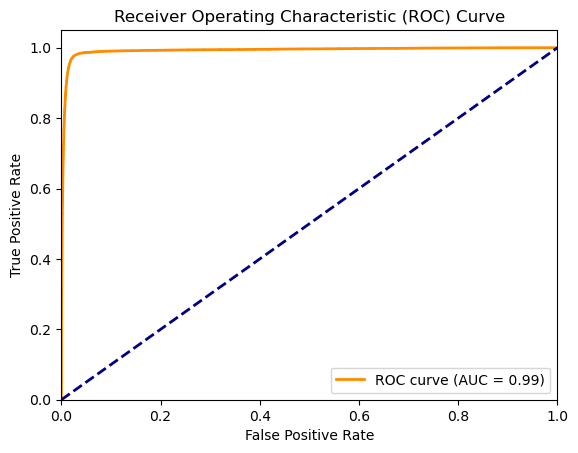

In [13]:
from sklearn.metrics import roc_curve, auc
y_prob = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

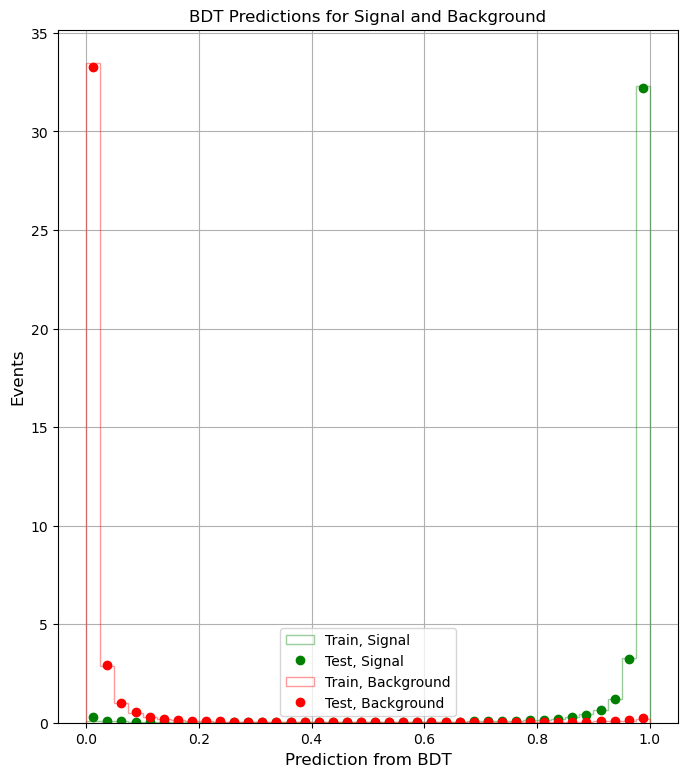

In [14]:
y_pred_signal_train = clf.predict_proba(X_train[y_train == 1])[:, 1]  # Predictions for training set, Signal
y_pred_signal_test = clf.predict_proba(X_test[y_test == 1])[:, 1]     # Predictions for test set, Signal
y_pred_background_train = clf.predict_proba(X_train[y_train == 0])[:, 1]  # Predictions for training set, Background
y_pred_background_test = clf.predict_proba(X_test[y_test == 0])[:, 1]     # Predictions for test set, Background

n_bins = 40
hist_range = (0, 1.0)
plt.figure(figsize=(8, 9))

plt.hist(y_pred_signal_train, bins=n_bins, range=hist_range, histtype='step', color="green", density=True, alpha=0.4, label="Train, Signal")
counts, bin_edges = np.histogram(y_pred_signal_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="green", label="Test, Signal")

plt.hist(y_pred_background_train, bins=n_bins, range=hist_range, histtype='step', density=True, alpha=0.4, color="red", label="Train, Background")
counts, bin_edges = np.histogram(y_pred_background_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="red", label="Test, Background")

plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend()
plt.grid()
plt.title("BDT Predictions for Signal and Background")
plt.show()


In [15]:
##########Validate###############

In [16]:
########Evaluation Part#################### 

In [17]:
val_s_file = up.open("/users/santoshp/BCVSPIN_Masterclass/BCVSPIN_Data/val_set/signal_val.root")
val_b_file = up.open("/users/santoshp/BCVSPIN_Masterclass/BCVSPIN_Data/val_set/bkg_val.root")
val_d_file = up.open("/users/santoshp/BCVSPIN_Masterclass/BCVSPIN_Data/val_set/data.root")

v_s_tree = val_s_file['tree']
v_b_tree = val_b_file['tree']
v_d_tree = val_d_file['tree']

branch_names = ['lep_pt_0','lep_pt_1','lep_pt_2','lep_pt_3','deltaR_l0_l1','deltaR_l0_l2','deltaR_l0_l3',
 'deltaR_l1_l2','deltaR_l1_l3','deltaR_l2_l3' ,'invariant_mass_4lep'
]
total_branch = branch_names + ['totalWeight', 'lep_eta_0', 'lep_eta_1', 'lep_eta_2', 'lep_eta_3', 
                               'lep_phi_0', 'lep_phi_1', 'lep_phi_2', 'lep_phi_3', 'lep_E_0', 
                               'lep_E_1', 'lep_E_2', 'lep_E_3', 'lep_n','jet_n' #,'invariant_mass_4lep'
                              ]

v_s_arrays = v_s_tree.arrays(branch_names, library="pd")
v_s_arrays_t = v_s_tree.arrays(total_branch, library="pd")

v_b_arrays = v_b_tree.arrays(branch_names, library="pd")
v_b_arrays_t = v_b_tree.arrays(total_branch, library="pd")

v_d_arrays = v_d_tree.arrays(branch_names, library="pd")
v_d_arrays_t = v_d_tree.arrays(total_branch, library="pd")


v_df_s = pd.DataFrame(v_s_arrays)
v_df_s_t = pd.DataFrame(v_s_arrays_t)

v_df_b = pd.DataFrame(v_b_arrays)
v_df_b_t = pd.DataFrame(v_b_arrays_t)

v_df_d = pd.DataFrame(v_d_arrays)
v_df_d_t = pd.DataFrame(v_d_arrays_t)

In [18]:
print("Total Signal events: ",len(v_df_s))
print("Total Bkg events: ",len(v_df_b))
print("Total Data events: ",len(v_df_d))


Total Signal events:  370040
Total Bkg events:  684349
Total Data events:  507


In [19]:
y_s = clf.predict_proba(v_df_s)
y_b = clf.predict_proba(v_df_b)
y_d = clf.predict_proba(v_df_d)

In [20]:
bdt_score_s = y_s[:,1]
bdt_score_b = y_b[:,1]
bdt_score_d = y_d[:,1]


In [21]:
v_df_s_t['bdt_score'] = bdt_score_s
v_df_b_t['bdt_score'] = bdt_score_b
v_df_d_t['bdt_score'] = bdt_score_d

In [22]:
################stack plot#########

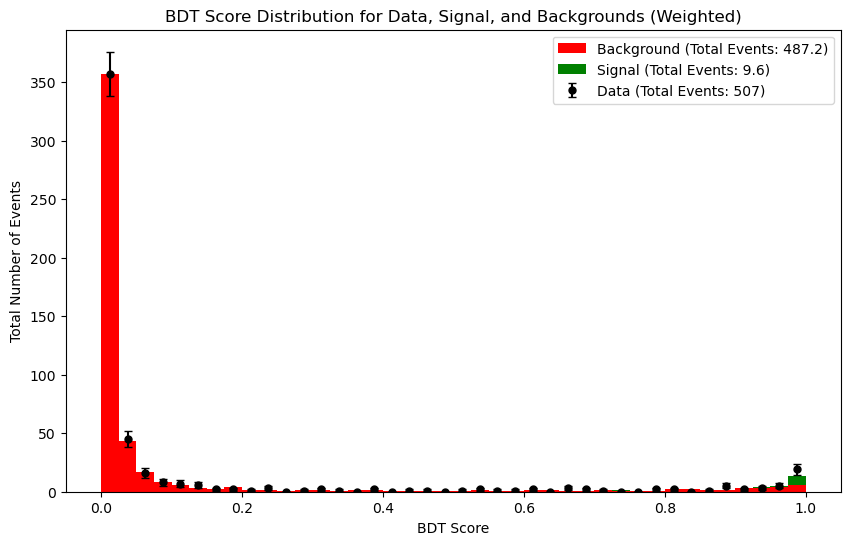

In [23]:
data_to_plot = [v_df_b_t['bdt_score'], v_df_s_t['bdt_score']]
weights_to_use = [v_df_b_t['totalWeight'], v_df_s_t['totalWeight']]

# Calculate event totals
total_signal = np.sum(v_df_s_t['totalWeight'])
total_background = np.sum(v_df_b_t['totalWeight'])
total_data = len(v_df_d_t)

# Stacked histogram for signal and background
plt.figure(figsize=(10, 6))
plt.hist(data_to_plot, bins=40, range=(0, 1), weights=weights_to_use, stacked=True, 
         label=[f'Background (Total Events: {total_background:.1f})', 
                f'Signal (Total Events: {total_signal:.1f})'],
         color=['red', 'green'])

# Calculate bin centers for data
bins = np.linspace(0, 1, 41)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Data histogram and errors
data_hist, _ = np.histogram(v_df_d_t['bdt_score'], bins=bins)
data_errors = np.sqrt(data_hist)


plt.errorbar(bin_centers, data_hist, fmt='o', yerr=data_errors,
             label=f'Data (Total Events: {total_data})', color='black', 
             markersize=5, capsize=3)

plt.title('BDT Score Distribution for Data, Signal, and Backgrounds (Weighted)')
plt.xlabel('BDT Score')
plt.ylabel('Total Number of Events')
# plt.yscale('log') 

plt.legend()
plt.show()

In [24]:
#Calculate Signigicance

In [25]:
# Define bins as before
bins = np.linspace(0, 1, 41)  # 20 bins from 0 to 1 (or adjust as needed)

# Calculate histograms for signal and background individually
signal_hist, _ = np.histogram(v_df_s_t['bdt_score'], bins=bins, weights=v_df_s_t['totalWeight'])
background_hist, _ = np.histogram(v_df_b_t['bdt_score'], bins=bins, weights=v_df_b_t['totalWeight'])

# Calculate the histogram for data as well
data_hist, _ = np.histogram(v_df_d_t['bdt_score'], bins=bins)

# Sum the counts in the last two bins for each histogram
# The last two bins are at indices -2 and -1
signal_last_two = signal_hist[-2:].sum()
background_last_two = background_hist[-1:].sum()
data_last_two = data_hist[-2:].sum()

# Print the values
print(f"Last two bins:\nSignal: {signal_last_two:.3f}\nBackground: {background_last_two:.3f}\nData: {data_last_two:.3f}")


Last two bins:
Signal: 8.408
Background: 6.066
Data: 24.000


In [26]:
# Calculate the significance in the last two bins
N_sig_last_two = signal_last_two
N_bg_last_two = background_last_two

# Apply the signal significance formula (adjust uncertainty model as needed)
signal_significance_last_two = N_sig_last_two / np.sqrt(N_bg_last_two + 0.3 * N_bg_last_two**2)
print(f"Signal Significance in Last Two Bins: {signal_significance_last_two:.3f}")


Signal Significance in Last Two Bins: 2.033


In [27]:
# Define observed signal as the excess of data over background
N_sig_observed_last_two = max(data_last_two - background_last_two, 0)  # Clip to avoid negative signal
N_bg_last_two = background_last_two  # Background remains the same

# Calculate observed significance
observed_significance_last_two = N_sig_observed_last_two / np.sqrt(N_bg_last_two + 0.3 * N_bg_last_two**2)

print(f"Observed Significance in Last Two Bins: {observed_significance_last_two:.3f}")


Observed Significance in Last Two Bins: 4.336
